# Week 3 Assignment
## Lasso Regression

In [1]:
%matplotlib inline

# Import libraries needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LassoLarsCV
from sklearn import preprocessing

# Make results reproducible
np.random.seed(1234567890)

df = pd.read_csv('gapminder.csv')

variables = ['incomeperperson', 'alcconsumption', 'co2emissions', 'femaleemployrate',
                'internetuserate', 'lifeexpectancy','polityscore','employrate','urbanrate']

# convert to numeric format
for variable in variables:
    df[variable] = pd.to_numeric(df[variable], errors='coerce')

# listwise deletion of missing values
subset = df[variables].dropna()

# Print the rows and columns of the data frame
print('Size of study data')
print(subset.shape)

Size of study data
(148, 9)


Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 30 days


## Data Management

In [2]:
# Remove the first variable from the list since the target is derived from it
variables.pop(0)

# Center and scale data
for variable in variables:
    subset[variable]=preprocessing.scale(subset[variable].astype('float64'))
    
# Identify contries with a high level of income using the MAD (mean absolute deviation) method
subset['absolute_deviations'] = np.absolute(subset['incomeperperson'] - np.median(subset['incomeperperson']))
MAD = np.mean(subset['absolute_deviations'])

# This function converts the income per person absolute deviations to a high income flag
def high_income_flag(absolute_deviations):
    threshold = 3
    if (absolute_deviations/MAD) > threshold:
        return 1
    else:
        return 0

subset['High Income'] = subset['absolute_deviations'].apply(high_income_flag)

/home/mike/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:167: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


## Build LASSO Regression Model

In [3]:
predictors = subset[variables]
targets = subset['High Income']

#Split into training and testing sets
training_data, test_data, training_target, test_target  = train_test_split(predictors, targets, test_size=.3)

# Build the LASSO regression model
model=LassoLarsCV(cv=10, precompute=False).fit(training_data, training_target)

## Evaluate LASSO Regression Model

In [4]:
# print variable names and regression coefficients
feature_name = list(predictors.columns.values)
feature_coefficient = list(model.coef_)
features = pd.DataFrame({'Variable':feature_name, 'Regression Coefficients':feature_coefficient}).sort_values(by='Regression Coefficients', ascending=False)
print(features.head(len(feature_name)))

   Regression Coefficients          Variable
3                 0.157313   internetuserate
1                 0.019681      co2emissions
6                 0.001853        employrate
0                 0.000000    alcconsumption
2                 0.000000  femaleemployrate
4                 0.000000    lifeexpectancy
5                 0.000000       polityscore
7                 0.000000         urbanrate


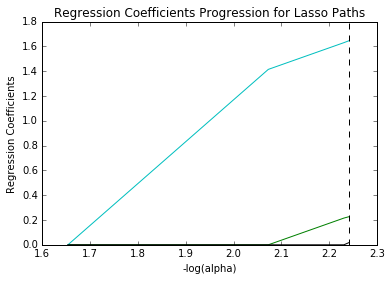

In [5]:
# plot coefficient progression
m_log_alphas = -np.log10(model.alphas_)
ax = plt.gca()
plt.plot(m_log_alphas, model.coef_path_.T)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k', label='alpha CV')
plt.ylabel('Regression Coefficients')
plt.xlabel('-log(alpha)')
plt.title('Regression Coefficients Progression for Lasso Paths')

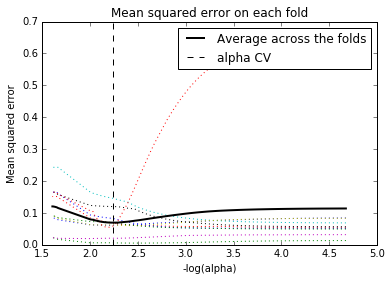

In [6]:
# plot mean square error for each fold
m_log_alphascv = -np.log10(model.cv_alphas_)
plt.figure()
plt.plot(m_log_alphascv, model.cv_mse_path_, ':')
plt.plot(m_log_alphascv, model.cv_mse_path_.mean(axis=-1), 'k', label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k', label='alpha CV')
plt.legend()
plt.xlabel('-log(alpha)')
plt.ylabel('Mean squared error')
plt.title('Mean squared error on each fold')

In [7]:
# MSE from training and test data
from sklearn.metrics import mean_squared_error
train_error = mean_squared_error(training_target, model.predict(training_data))
test_error = mean_squared_error(test_target, model.predict(test_data))
print ('training data MSE')
print(train_error)

training data MSE
0.0673628062597


In [8]:
print ('test data MSE')
print(test_error)

test data MSE
0.0644442545783


In [9]:
# R-square from training and test data
rsquared_train=model.score(training_data, training_target)
rsquared_test=model.score(test_data, test_target)
print ('training data R-square')
print(rsquared_train)

training data R-square
0.426443008339


In [10]:
print ('test data R-square')
print(rsquared_test)

test data R-square
0.44230933538
